In [2]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from utils.labels import trainId2label
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

In [3]:
# Path to Cityscapes dataset
CITYSCAPES_DIR = "data"
IMAGES_DIR = os.path.join(CITYSCAPES_DIR, "leftImg8bit_trainvaltest/leftImg8bit/train")
LABELS_DIR = os.path.join(CITYSCAPES_DIR, "gtFine_trainvaltest/gtFine/train")
# Limit the number of images to process
# Limit the number of images and pixels
LIMIT_IMAGES = 2975  # Number of images to sample
MAX_PIXELS = 1000000  # Max number of pixels to process
LABEL_ID = 7 # road

In [4]:
def get_city_folders(directory):
    """Retrieve all city subfolders."""
    return [os.path.join(directory, city) for city in os.listdir(directory) if os.path.isdir(os.path.join(directory, city))]


In [5]:
def get_image_label_pairs(images_dir, labels_dir):
    """Match RGB images with their corresponding label IDs."""
    image_label_pairs = []
    for city_folder in get_city_folders(images_dir):
        city_name = os.path.basename(city_folder)
        label_city_folder = os.path.join(labels_dir, city_name)

        for image_file in os.listdir(city_folder):
            if image_file.endswith("_leftImg8bit.png"):
                # Image path
                image_path = os.path.join(city_folder, image_file)
                # Corresponding label file
                label_file = image_file.replace("_leftImg8bit.png", "_gtFine_labelIds.png")
                label_path = os.path.join(label_city_folder, label_file)
                if os.path.exists(label_path):
                    image_label_pairs.append((image_path, label_path))
                    if len(image_label_pairs) >= LIMIT_IMAGES:  # Stop if limit is reached
                        return image_label_pairs
    return image_label_pairs


In [6]:
def preprocess_data(image_label_pairs, max_pixels=MAX_PIXELS, label_Id=LABEL_ID):
    """Extract pixel RGB values and labels for training."""
    X = []  # Pixel RGB values
    y = []  # Binary labels (road or not road)
    total_pixels = 0
    pixels_per_image = max_pixels // LIMIT_IMAGES //2
    for image_path, label_path in tqdm.tqdm(image_label_pairs):
        # Load RGB image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        # Load label image
        label_img = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
        
        # Flatten image and labels into 1D arrays
        image_pixels = image.reshape(-1, 3)  # RGB values
        label_pixels = label_img.flatten()  # Label IDs
        
        # Filter for road (TrainId = 7) and not-road
        road_mask = (label_pixels == label_Id)
        not_road_mask = ~road_mask
        
        # Create subsets for road and not-road pixels
        road_pixels = image_pixels[road_mask]
        not_road_pixels = image_pixels[not_road_mask]

        # Randomly sample pixels from each image
        sampled_road_pixels = road_pixels[np.random.choice(road_pixels.shape[0], min(pixels_per_image, road_pixels.shape[0]), replace=False)]
        sampled_not_road_pixels = not_road_pixels[np.random.choice(not_road_pixels.shape[0], min(pixels_per_image, not_road_pixels.shape[0]), replace=False)]
        
        # Append the samples to the data
        X.extend(sampled_road_pixels)
        y.extend([1] * len(sampled_road_pixels))  # Road pixels labeled as 1
        
        X.extend(sampled_not_road_pixels)
        y.extend([0] * len(sampled_not_road_pixels))  # Not-road pixels labeled as 0
        
        total_pixels += len(sampled_road_pixels) + len(sampled_not_road_pixels)
        
        # Stop if we reach the max pixel limit
        if total_pixels >= max_pixels:
            break

    return np.array(X), np.array(y)

In [ ]:
# Get image-label pairs
image_label_pairs = get_image_label_pairs(IMAGES_DIR, LABELS_DIR)

# Preprocess data with pixel limit
X, y = preprocess_data(image_label_pairs, max_pixels=MAX_PIXELS)


 11%|█         | 331/2975 [00:34<04:33,  9.68it/s]

In [ ]:
print(f"Processed {len(X)} pixels")
print(f"Number of road pixels: {np.sum(y)}")
print(f"Number of not road pixels: {len(y) - np.sum(y)}")

Processed 992712 pixels
Number of road pixels: 492912
Number of not road pixels: 499800


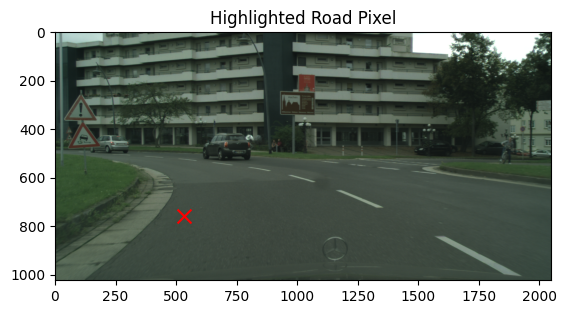

In [ ]:
def plot_random_road_pixel(image_path, label_path, pixels_per_image=1000,label_Id=LABEL_ID):
    """
    Load an image and its label, and highlight a randomly selected road pixel.
    
    Parameters:
        image_path (str): Path to the RGB image.
        label_path (str): Path to the label image.
        pixels_per_image (int): Number of pixels to sample from the image.
    """
    # Load the image and label
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    label_img = cv2.imread(label_path, cv2.IMREAD_UNCHANGED)
    
    # Flatten image and labels into 1D arrays
    image_pixels = image.reshape(-1, 3)  # RGB values
    label_pixels = label_img.flatten()  # Label IDs
    
    # Filter for road (TrainId = 7)
    road_mask = (label_pixels == label_Id)
    road_pixels = image_pixels[road_mask]

    # Randomly sample a road pixel
    if len(road_pixels) > 0:
        sampled_road_pixel = road_pixels[np.random.choice(road_pixels.shape[0], 1)]
        road_pixel_index = np.where(label_pixels == label_Id)[0][np.random.choice(len(road_pixels), 1)]
        
        # Get pixel coordinates (row, col)
        row, col = divmod(road_pixel_index[0], label_img.shape[1])
        
        # Plot the image
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.scatter(col, row, color='red', s=100, marker='x')  # Mark the road pixel
        plt.title('Highlighted Road Pixel')
        plt.show()

# Example usage:
image_path = 'data/leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png'
label_path = 'data/gtFine_trainvaltest/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png'

plot_random_road_pixel(image_path, label_path)

In [ ]:
# Normalize RGB values
X = X / 255.0  # Scale RGB to [0, 1]

In [ ]:
# Model training pipeline
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
# Build pixel classifier
def build_pixel_classifier():
    model = models.Sequential([
        layers.Input(shape=(3,)),  # RGB input
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')  # Output: road (1) or not road (0)
    ])
    return model

In [ ]:
# Build and compile the model
model = build_pixel_classifier()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Split data into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_val, y_val))

Epoch 1/10
3103/3103 [==============================] - 18s 6ms/step - loss: 0.5502 - accuracy: 0.7193 - val_loss: 0.5194 - val_accuracy: 0.7483
Epoch 2/10
3103/3103 [==============================] - 19s 6ms/step - loss: 0.5143 - accuracy: 0.7504 - val_loss: 0.5173 - val_accuracy: 0.7504
Epoch 3/10
3103/3103 [==============================] - 18s 6ms/step - loss: 0.5114 - accuracy: 0.7527 - val_loss: 0.5106 - val_accuracy: 0.7539
Epoch 4/10
3103/3103 [==============================] - 18s 6ms/step - loss: 0.5081 - accuracy: 0.7553 - val_loss: 0.5071 - val_accuracy: 0.7554
Epoch 5/10
3103/3103 [==============================] - 19s 6ms/step - loss: 0.5048 - accuracy: 0.7575 - val_loss: 0.5111 - val_accuracy: 0.7517
Epoch 6/10
3103/3103 [==============================] - 19s 6ms/step - loss: 0.5014 - accuracy: 0.7597 - val_loss: 0.5007 - val_accuracy: 0.7604
Epoch 7/10
3103/3103 [==============================] - 18s 6ms/step - loss: 0.4984 - accuracy: 0.7620 - val_loss: 0.5017 - val_ac

In [ ]:
#plot the confusion matrix of the model so i can see f1, accuracy, ecc...
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_val, y_pred)
#print classification report
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


NameError: name 'model' is not defined

6205/6205 [==============================] - 6s 1ms/step


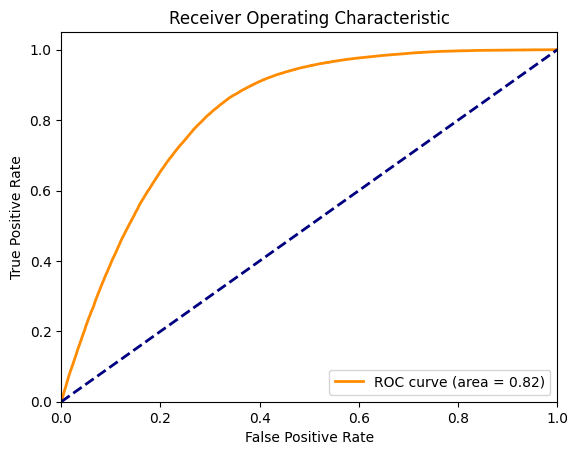

In [ ]:
# plot roc curve
from sklearn.metrics import roc_curve, auc
y_pred = model.predict(X_val)

fpr, tpr, threshold = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
